In [2]:
# Import all modules.
import numpy as np
import pandas as pd
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models


In [3]:
csv_pa=pd.read_csv("/content/role_challenge_dataset_ground_truth - role_challenge_dataset_ground_truth.csv.csv")
csv_pa.head()

,image_name,ofd_1_x,ofd_1_y,ofd_2_x,ofd_2_y,bpd_1_x,bpd_1_y,bpd_2_x,bpd_2_y
0,000_HC.png,361,12,339,530,481,16,664,318
1,001_HC.png,441,331,368,308,297,247,534,142
2,002_HC.png,318,374,154,406,481,158,558,215
3,003_HC.png,424,105,407,462,305,349,547,363
4,004_HC.png,300,277,611,534,53,452,494,308


In [4]:
# Check for null values.
csv_pa.isnull().sum()

image_name    0
ofd_1_x       0
ofd_1_y       0
ofd_2_x       0
ofd_2_y       0
bpd_1_x       0
bpd_1_y       0
bpd_2_x       0
bpd_2_y       0
dtype: int64

In [5]:
csv_pa.shape

(317, 9)

In [6]:
# Working on zip file.
# My idea is to create folder from zip file as to easy in use.

import zipfile

# Specify the name of the uploaded zip file
zip_file= "/content/New assi.zip"

# Specify the extraction directory
extract_dir = "my_images"

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

ITS END RESULT IS TO CREATE A FOLDER MY_IMAGES IN WHICH ALL MY IMAGES ARE THERE.

In [7]:
# Set the path to your images folder
images_path = "/content/my_images/images"

In [11]:
# Function to read and preprocess images
def read_and_preprocess_image(image_path):
    pic = cv2.imread(os.path.join(images_path, image_path))
    if pic is not None:
        # Resize the image to (800, 540) or any desired size  But i checked all my images are in (800,540) shape,but for safety.
        pic = cv2.resize(pic, (800, 540))
        # Normalize the pixel values to the range [0, 1] and convert to float32
        pic = pic.astype('float32') / 255.0
    return pic

In [13]:
#Now its time to read images.
image_name = csv_pa['image_name']
images = []

for name in image_name:
    process_image = read_and_preprocess_image(name)
    images.append(process_image)

images = np.array(images)

marks=csv_pa.iloc[:,1:].to_numpy()


In [15]:
# Now I wan't to ensure that all images are valid means not null images.
valid_indi = []

for i, img in enumerate(images):
    if img is not None:
        valid_indi.append(i)



In [16]:
# Now i want to convert my marks and my images to a float datatype to ensure that all are in same datatype.
images = images[valid_indi].astype(np.float32)  # Convert to float32
marks = marks[valid_indi].astype(np.float32)  # Convert to float32

In [17]:
# Checking the shape
marks.shape

(317, 8)

# NOTE I simply cutoff some data because my computation power exceed .

In [18]:
# Now its time to split my data into train and test.
X_train, X_test, y_train, y_test = train_test_split(images, marks, test_size=0.3, random_state=42)

In [19]:
# Build my model artitecture.
model=models.Sequential()
model.add(layers.Conv2D(30, (3, 3), activation='relu', input_shape=(540, 800, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(60, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(126, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())

# Dense layers.
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(126, activation='relu'))
model.add(layers.Dense(62, activation='relu'))
model.add(layers.Dense(8))        # 4 landmarks with x and y coordinates
# Compile
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

Unfortunately my system ram is not too high so i didn't run for higher epochs.

In [20]:
# Train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
7/7 [==============================] - 31s 2s/step - loss: 75555.6641 - mse: 75555.6641 - val_loss: 21626.7520 - val_mse: 21626.7520
Epoch 2/5
7/7 [==============================] - 3s 511ms/step - loss: 23628.2090 - mse: 23628.2090 - val_loss: 20551.1289 - val_mse: 20551.1289
Epoch 3/5
7/7 [==============================] - 4s 531ms/step - loss: 21288.9199 - mse: 21288.9199 - val_loss: 15165.5830 - val_mse: 15165.5830
Epoch 4/5
7/7 [==============================] - 4s 537ms/step - loss: 17755.0000 - mse: 17755.0000 - val_loss: 17822.7559 - val_mse: 17822.7559
Epoch 5/5
7/7 [==============================] - 4s 534ms/step - loss: 15242.4385 - mse: 15242.4385 - val_loss: 13573.3896 - val_mse: 13573.3896


As we observe loss is high but if we run upto 100 or may be more with earlystopping then result will be good.

In [23]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(X_test)


3/3 [==============================] - 1s 158ms/step


In [25]:
# Randomly select 10 indices for visualization
sample_indi = np.random.choice(len(X_test), size=10, replace=False)

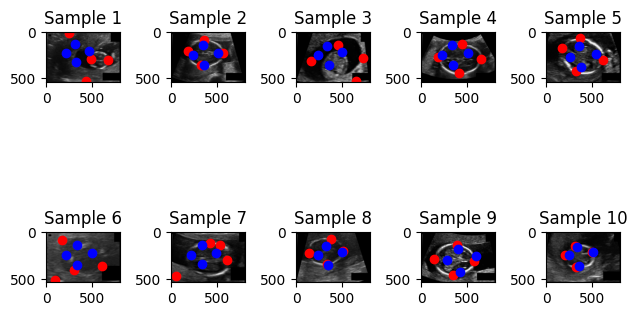

In [26]:
# Plot it.
for i, sample_index in enumerate(sample_indi):
    original_image = X_test[sample_index]
    marks_true = y_test[sample_index]
    marks_predicted = predictions[sample_index]

    plt.subplot(2, 5, i + 1)
    plt.imshow(original_image)
    plt.scatter(marks_true[0::2], marks_true[1::2], c='r', marker='o', label='True Landmarks')
    plt.scatter(marks_predicted[0::2], marks_predicted[1::2], c='b', marker='o', label='Predicted Landmarks')
    plt.title(f"Sample {i+1}")

plt.tight_layout()
plt.show()

NOTE: If we train with higher epochs with proper hyperparameter selection this model works good